In [1]:
import numpy as np
import matplotlib.pyplot as plt

The basic form of our problem is that an individual has a preference for a threshold value in the unit-interval, but we can only solicit the direction of the optimum relative to a comparison threshold. In practice, to solicit this direction we compare the values $\lambda \pm \epsilon_0$. However, the closer the more likely our comparison will return the wrong result. 

**Theorem:** Say we have an oracle that given $\lambda \in [0,1]$ points in the direction of $\lambda_0$. The Bayesian update for the location of $\lambda_0$ given a collection of oracle queries is a simple function.

**Proof:** We have,
$$
P(\text{Optimum is at } \lambda_0 | \text{Right Preference at } \lambda) $$ $$ = \cfrac{P(\text{Right Preference at } \lambda | \text{Optimum is at } \lambda_0) \cdot P(\text{Optimum is at } \lambda_0)}{\sum_i P(\text{Preference}_i \text{ at } \lambda | \text{Optimum is at } \lambda_0)} $$ $$
\Rightarrow P_{n+1}(\text{Optimum is at } \lambda_0)= \begin{cases} \cfrac{\alpha}{N} P_n(\text{Optimum is at } \lambda_0) \ \lambda > \lambda_0 \\
\cfrac{1-\alpha}{N} P_n(\text{Optimum is at } \lambda_0) \text{ otherwise} \end{cases}
$$
Since $P_0 = 1$ then $P_1$ is a simple function. Assume for $k = n$ we have that $P_k$ is a simple function. From the above, if $P_k$ is a smple function we see $P_{k+1}$ is a simple function. By induction, $P_n$ for all $n$ is a simple function.

This will guide the creation of our basic data-type for individual preferences since this we now know these will be a simple-function of the queries.

In [333]:
class Simple_Dist:
    
    # param = [(points,values)]
    # constructed left-to-right on [0,1]
    def __init__(self, init):
        self.param = init
        
    def display(self):
        points = []
        a_param = self.param + [(1,self.param[-1][1])]
        for i, v in enumerate(a_param[:-1]):
            points.append(v)
            points.append((a_param[i+1][0],v[1]))
        x,y = zip(*points)
        plt.plot(x,y)
        plt.title("Median Density")
        plt.ylabel("Density")
        plt.xlabel("Value")
    
    def cdf(self,threshold):
        basis = []
        val = []
        a_param = self.param + [(1,self.param[-1][1])]
        for i, v in enumerate(a_param):
            if v[0] < threshold:
                basis.append(v[0])
                val.append(v[1])
            else:
                basis.append(threshold)
                cdf = 0
                for i, d in enumerate(val):
                    cdf += d*(basis[i+1]-basis[i])
                return cdf
    
    def median(self):
        left = 0
        right = 1
        val = self.cdf(0.5*(left+right))
        while True:
            val = self.cdf(0.5*(left+right))
            # Can this be made 'exact?'
            if abs(val-0.5) > 0.0001:
                if val < 0.5:
                    left = 0.5*(left+right)
                else:
                    right = 0.5*(left+right)
            else:
                return 0.5*(left+right)
    
    # Vote indicates 
    def update_dist(self, threshold, vote, alpha = 0.1):
        
        # Insert new data
        index = next(i for i,v in enumerate(self.param+[(1,self.param[-1][1])]) if threshold < v[0])
        if index < len(self.param) and self.param[index][0] != threshold:
            self.param.insert(index,(threshold,self.param[index-1][1]))
        elif index >= len(self.param):
            self.param.insert(index,(threshold,self.param[index-1][1]))
            
        # Modify distribution
        if vote == -1:
            r_mass = 1 - self.cdf(threshold)
            for i, v in enumerate(self.param):
                if v[0] < threshold:
                    self.param[i] = (v[0],v[1] * (1 - alpha))
                else:
                    self.param[i] = (v[0],v[1] * alpha)
            norm = self.cdf(1)
            for i, v in enumerate(self.param):
                self.param[i] = (v[0], v[1]/norm)
        else:
            l_mass = self.cdf(threshold)
            for i, v in enumerate(self.param):
                if v[0] >= threshold:
                    self.param[i] = (v[0],v[1] * (1 - alpha))
                else:
                    self.param[i] = (v[0],v[1] * alpha)
            norm = self.cdf(1)
            for i, v in enumerate(self.param):
                self.param[i] = (v[0], v[1]/norm)

We can perform some basic sanity checks by setting up setting up a few queries starting with a uniform distribution. Each query indicates a threshold and then is $+1$ if the optimum lays to the right and is $-1$ if the optimum lies to the left. Our $\alpha$ parameter indicates the error rate of the queries. Also note that we are ignoring the $\epsilon_0$ spacing that is needed to ensure $\alpha < 1/2$. 

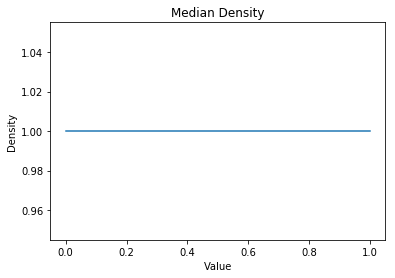

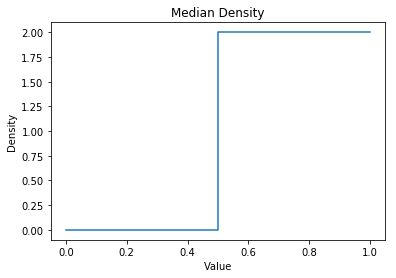

In [335]:
# Basic Demo
alpha = 0.0
dist = Simple_Dist([(0,1)])
dist.display()
plt.show()
dist.update_dist(dist.median(),1, alpha = alpha)
dist.display()
plt.show()

We can randomly sample queries and see how the distribution evolves over time. In expectation, each threshold on the line either gains or loses probability at each round. Using the law of large numbers we can conclude that the threshold that loses the least evidence in each round is the optimum threshold. We can also extract a linear convergence rate. 

0.3936767578125


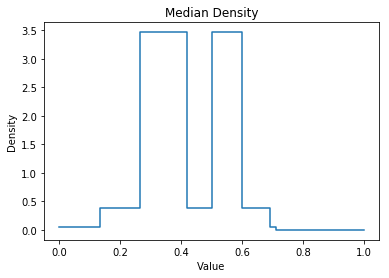

In [344]:
# Oracle at 0.3 with 0.1 error rate
# Random query strategy
dist = Simple_Dist([(0,1)])
dist.update_dist(0.5,1, alpha = alpha)
opt = 0.3
alpha = 0.1
num = 10
query = np.random.rand(num,2)
for i in range(num):
    if query[i][0] < opt:
        if query[i][1] > alpha:
            dist.update_dist(query[i][0],1, alpha = alpha)
        else:
            dist.update_dist(query[i][0],-1, alpha = alpha)
    else:
        if query[i][1] > alpha:
            dist.update_dist(query[i][0],-1, alpha = alpha)
        else:
            dist.update_dist(query[i][0],1, alpha = alpha)
dist.display()
print(dist.median())

In the active learning setting we can pick which thresholds to query on. This allows for an exponential speedup over random sampling. However, showing this is much more involved. 

Up to this point we've been studying how to select optimal threshold queries so that we can update an individual preference distribution. What we'd like to do is aggregate preferences across multiple individuals. If preferences were known, we could use a Condorcet strategy and then we'd just take the median of the individual preferences as the aggregate preference. To generalize, we would want to calculate the median distribution of the individual preferences and then return the mean. Doing this is bit tricky as it requires the calculation of $k$-th order statistics. 

**Lemma:** Let $z_1, \ldots, z_n$ be a collection of independent random variables with PDFs $p_i$ and CDFs $C(p_i)$. Additionally, let $Z_{N}^{(k)}$ be the $k$-th order statistic among the $(z_i)_{i \in N}$ with PDF $P_{N}^{(k)}$ and CDF $C(P_N^{(k)})$. We have the recurrences,
$$
C(P_N^{(k)} )= C(P_{N-1}^{(k)}) + C(p_N) [C(P_{N-1}^{(k-1)}) - C(P_{N-1}^{(k)})] $$ $$
P_N^{(k)} = P_{N-1}^{(k)} + p_N [C(P_{N-1}^{(k-1)}) - C(P_{N-1}^{(k)})] + C(p_N) [P_{N-1}^{(k-1)} - P_{N-1}^{(k)}]
$$
**Proof:** If we remove the variable $z_n$ either $Z^{(k)}_{N-1}$ is still less than $\lambda$ or we see that $Z_{N-1}^{(k-1)} \le \lambda < Z_{N-1}^{(k)}$ and $Z_N \le \lambda$. Writing out the explicit probability makes things clear,
$$
\lbrace Z^{(k)}_N \le \lambda \rbrace \iff \lbrace Z^{(k)}_{N-1} \le \lambda \rbrace \cup \lbrace Z_{N-1}^{(k-1)} \le \lambda < Z_{N-1}^{(k)} \rbrace \cap \lbrace z_N \le t \rbrace $$ $$
\iff C(P_N^{(k)}) = C(P^{(k)}_{N-1}) + C(p_N) [C(P_{N-1}^{(k-1)})  - C(P_{N-1}^{(k)})]
$$
The last term follows from the [inclusion-exclusion principle](https://en.wikipedia.org/wiki/Inclusion%E2%80%93exclusion_principle#In_probability). Differentiation yields,
$$
\Rightarrow P_N^{(k)} = P_{N-1}^{(k)} + p_N [C(P_{N-1}^{(k-1)}) - C(P_{N-1}^{(k)})] + C(p_N) [P_{N-1}^{(k-1)} - P_{N-1}^{(k)}]
$$
Note that we'll set need to set $C(P_N^{(0)}) = 1$ and $P_N^{(0)} = 0$ for consistency. $\square$

**Corollary:** The $k$-th order statistics can be calculated in $O(n^2)$ time. 

In [347]:
def joint_CDF(voters, threshold):
    C = np.zeros((len(voters), len(voters)+1))
    for n in range(len(voters)):
        C[n,0] = 1
    C[0,1] = voters[0].cdf(threshold)
    for k in range(1,len(voters)+1):
        for n in range(1, len(voters)):
            C[n,k] = C[n-1,k]+voters[n].cdf(threshold)*(C[n-1,k-1] - C[n-1,k])
    return C

def joint_ent(voters):
    num = 100
    cdf = []
    for threshold in np.linspace(0.0,1,num = num):
        cdf.append(joint_CDF(voters,threshold)[-1,1:])
    pdf = []
    for i in range(num-1):
        pdf.append(tuple(num*(cdf[i+1]-cdf[i])))
    v = list(zip(*pdf))
    return np.sum(-v[0][2] * np.log(v[0][2]))

def joint_plot(voters):
    num = 100
    cdf = []
    for threshold in np.linspace(0.0,1,num = num):
        cdf.append(joint_CDF(voters,threshold)[-1,1:])
    pdf = []
    for i in range(num-1):
        pdf.append(tuple(num*(cdf[i+1]-cdf[i])))
    v = list(zip(*pdf))
    plt.plot(np.linspace(0.0,1,num = num)[:-1],v[2])
    plt.title("K-th Order Statistics")

Text(0.5, 1.0, 'K-th Order Statistics')

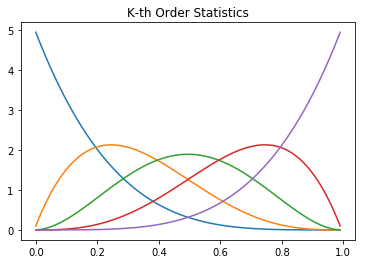

In [348]:
voters = [Simple_Dist([(0,1)]) for i in range(5)]
num = 100
cdf = []
for threshold in np.linspace(0.0,1,num = num):
    cdf.append(joint_CDF(voters,threshold)[-1,1:])
pdf = []
for i in range(num-1):
    pdf.append(tuple(num*(cdf[i+1]-cdf[i])))
v = list(zip(*pdf))
for i in range(len(voters)):
    plt.plot(np.linspace(0.0,1,num = num)[:-1],v[i])
plt.title("K-th Order Statistics")

Since this is just proof of concept we'll use a finite-difference approximation for the PDF to avoid creating a second recursion. Note that the distribution of the median resembles a normal distribution.

To continue, we need a heuristic to determine which voter-threshold query to sample given the current individual preferences. For the individual case this is intuitive. If we take the median of the distribution then we'll maximize the information gain from each query. 

It would make sense to maximize information gain of each query here as well. However, we can't just pick the voter with the median closest to the aggregate. It's possible the distribution is placed over the median, but is thin. Instead we'll go with a heuristic. We'll pick the median over the individual preferences that delivers the largest information gain. In the worst, case, it has performance equivalent to updating directly on the aggregate distribution. 

When we update an individual at the median we transfer $p \to p_l$ or $p \to p_r$ and then we have $H \to H_l$ or $H \to H_r$. Thus, the expected information gain is,

$$H - \frac{1}{2} \cdot(H_l + H_r)$$

This is easily described with our setup.

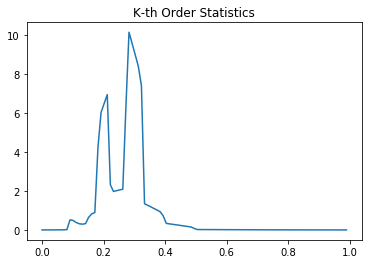

In [350]:
# 5 voters with median preference at 0.3 each with 0.1 error rate
voters = [Simple_Dist([(0,1)]) for i in range(5)]
opt = [0.1,0.2,0.3,0.5,0.8]
alpha = 0.1
num = 20
query = np.random.rand(num,2)
for i in range(num):
    value = []
    for j in range(0,len(voters)):
        query[i][0] = voters[j].median()
        prior_ent = joint_ent(voters)
        voters[j].update_dist(query[i][0],1, alpha = alpha)
        l_ent = joint_ent(voters)
        voters[j].update_dist(query[i][0],-1, alpha = alpha)
        voters[j].update_dist(query[i][0],-1, alpha = alpha)
        r_ent = joint_ent(voters)
        voters[j].update_dist(query[i][0],1, alpha = alpha) 
        value.append(prior_ent - 0.5*(l_ent + r_ent))
    j_opt = np.argmax(value)
    query[i][0] = voters[j_opt].median()
    if query[i][0] < opt[j_opt]:
        if query[i][1] > alpha:
            voters[j_opt].update_dist(query[i][0],1, alpha = alpha)
        else:
            voters[j_opt].update_dist(query[i][0],-1, alpha = alpha)
    else:
        if query[i][1] > alpha:
            voters[j_opt].update_dist(query[i][0],-1, alpha = alpha)
        else:
            voters[j_opt].update_dist(query[i][0],1, alpha = alpha)
joint_plot(voters)

The distributions generated here are much 'messier' than what we tend to get from our individual elicitation strategy. The main reason for this is that the median distribution is not simple even if the underlying distributions are. However, the accuracy, seems to be slightly higher for the same number of samples. 

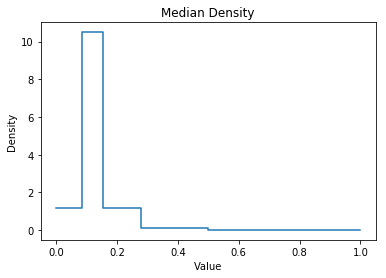

In [355]:
# Oracle at 0.3 with 0.1 error rate
# Median query strategy
dist = Simple_Dist([(0,1)])
opt = [0.1,0.2,0.3,0.5,0.8]
alpha = 0.1
num = 4
query = np.random.rand(num,2)
for i in range(num):
    query[i][0] = dist.median()
    vote = []
    for j in range(len(voters)):
        if query[i][0] < opt[j]:
            if query[i][1] > alpha:
                vote.append(1)
            else:
                vote.append(-1)
        else:
            if query[i][1] > alpha:
                vote.append(-1)
            else:
                vote.append(1)
    if sum(vote) > 0:
        dist.update_dist(query[i][0], 1, alpha = alpha)
    else:
        dist.update_dist(query[i][0], -1, alpha = alpha)
dist.display()